
# `Занятие 8: Архитектура Transformer`

`Воробьев Сергей | t.me/serv01 | sergei.vorobyov01@gmail.com`


Оригинал ноутбука можно найти тут
[here](https://github.com/harvardnlp/annotated-transformer/).

# `1. Введение`

## `1.1 Постановка задачи машинного перевода`
Давайте для начала разберем seq-to-seq задачу машинного перевода (Machine Translation). Ко всем подобным задачам есть общий подход.

Пусть у нас имеется предложение на исходном языке:
$$
\textbf{x}_{sourse} = x_{i}, i \in [1, n], x_{i} \in V_{sourse}
$$
Предложение на целевом языке:
$$
\textbf{y}_{target} = y_{i}, i \in [1, m], x_{i} \in V_{target}
$$
Параллельный корпус текстов $\textbf{C}$ из пар $(\textbf{x}, \textbf{y})$.
Строго говоря, решается задача максимизации лог-правдоподобия с параметрами $\theta$:
$$
L_{theta} = \sum_{\textbf{x},\textbf{y} \in \textbf{C}} \log p(\textbf{y}|\textbf{x};\theta) \rightarrow \max_{\theta}
$$
Предсказываем последовательно каждый целевой токен перевода в
зависимости от предыдущих (авторегрессионная модель):
$$
p(\textbf{y}|\textbf{x};\theta) = \prod_{j=1}^{m} p(\textbf{y}_{j}|\textbf{y}_{<j},\textbf{x};\theta)
$$
Для задачи перевода существуют и другие подходы, помимо авторегрессионного [cite](https://arxiv.org/pdf/2204.09269.pdf), однако, он является самым популярным.

Базовые архитектуры для решения seq-to-seq задач использует схему кодировщик-декодировщик. В качестве энкодера и декодера обычно берут рекуррентную сеть типа LSTM или GRU:
![Seq-to-Seq](https://sun9-25.userapi.com/impg/lAfWXLvO7bHTSRrLlPJnQz4t8g3g8a9wxNbIig/6otSRhUyqdI.jpg?size=2014x658&quality=96&sign=7fae89512fa58b6f16e55a5fffb4b876&type=album)
Мотивация использования именно таких архитектур заключается в том, что мы не знаем, какой длины у нас будет вход и выход. Более того, их длины обычно отличаются друг от друга.

Узким местом такой архитектуры является вектор $h$, поскольку:
-  Мы хотим уместить весь смысл текста в вектор низкой размерности.
- Вектор $h$ гораздо сильнее зависит от последних слов, нежели от первых.

К тому же, качество такой модели очень сильно падает, если мы пытаемся отправлять в неё последовательности длиннее, чем те, что были в трейне. Необходимо также упомянуть проблему выравнивания (alignment) при обучении языковых моделей. Она заключается в том, что при переводе или генерации текста необходимо учитывать соответствие между словами исходного и целевого языков. Так как слова в разных языках могут иметь различную длину и порядок, то необходимо найти соответствие между ними. Эта проблема становится особенно актуальной при переводе сложных фраз или предложений, когда необходимо учитывать контекст и смысл слов.

## `1.2 Attention is all you need`
Исправить проблемы, описанные выше, помог механизм внимания [cite](https://arxiv.org/pdf/1409.0473.pdf).

Механизм attention в нейронных сетях позволяет модели сосредоточиться на наиболее важных частях входных данных, игнорируя несущественные. Это позволяет сети лучше понимать контекст и улучшать качество предсказаний. Так, в задаче машинного перевода механизм attention позволяет сети решить проблему выравнивания (alignment) и сфокусироваться на ключевых словах и фразах в исходном тексте, что приводит к более точному переводу.

Очень хорошо attention описывает этот слайд из лекции [cite](https://www.youtube.com/watch?v=KhMweP00S44):


<!-- Строго, механизм можно описать так:
- Пусть $a(h, h')$ - функция сходства состояний входа $h$ и выхода $h'$.
- $\alpha_{ti}$ – важность входа $i$ для выхода $t$ (attention score), $\sum_{i}\alpha_{ti} = 1$
- $c_{i}$ – вектор входного контекста для выхода $t$ (context vector) -->

<div>
<img src="https://sun9-37.userapi.com/impg/3gXx6Hi0ylW2VpWyX8Ahp1UlHdUTyBpl0JYlQQ/L9PTei0xScU.jpg?size=1952x1126&quality=96&sign=f46c91e25deb4d3f3d330c0044067e7b&type=album" width="700"/>
</div>

Введем обозначения: 
- Вектор выходной последовательности $h'_{t-1}$, по которому мы хотим предсказать следующий вектор назовем запросом (**query**).
- Вектора входной последовательности $h_{i}$ назовем ключами (**keys**)
- Они же и будут являеться значениями (**values**), по которым мы возьмем взвешенную сумму $c_t$.

### Линейные преобразования векторов
Чтобы сделать механизм attention обучаемым и более гибким, можно ввести проекционные матрицы для query, key, value.

### Scaled Dot-Product Attention

Рассмотрим механизм "Scaled Dot-Product Attention", который понадобится нам в дальнейшем в трансформере. На вход подаются **запросы** и **ключи** размерности $d_k$ и **значения** размерности $d_v$. Далее считается скалярное произведение запроса со всеми ключами, каждый результат делится на $\sqrt{d_k}$ и далее применяется softmax, чтобы получить веса для **значений**.

<center><div>
<img src="https://sun9-43.userapi.com/impg/_4nneD33lDOOmUM9nsOjWTnwTPgnmg6pVORdbg/ARWXc-to5LQ.jpg?size=756x1304&quality=96&sign=520a1f13854527903c860231d08ba081&type=album" width="200"/>
</div></center>


<!-- In practice, we compute the attention function on a set of queries
simultaneously, packed together into a matrix $Q$.  The keys and
values are also packed together into matrices $K$ and $V$.  We
compute the matrix of outputs as: -->

На практике, Attention считается для всех **запросов** одновременно – они запаковываются в матрицу $Q$. **Ключи** и **значения** также запакованы в матрицы $K$ и $V$ соответсвенно. Выходная матрица считается следующим образом:

$$
   \mathrm{Attention}(Q, K, V) = \mathrm{softmax}(\frac{QK^T}{\sqrt{d_k}})V
$$

Деление на $\sqrt{d_k}$ нужно чтобы уменьшить дисперсию скалярного произведение и избежать больших чисел под экспонентой.

Реализуем этот механизм:

In [ ]:
def attention(query, key, value, mask=None, dropout=None):
    "Compute 'Scaled Dot Product Attention'"
    d_k = query.size(-1)
    scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)
    p_attn = scores.softmax(dim=-1)
    if dropout is not None:
        p_attn = dropout(p_attn)
    return torch.matmul(p_attn, value), p_attn

## `1.4 Импорты`

In [ ]:
!pip install -q torchtext altair GPUtil
# !pip install -q spacy
# !python -m spacy download de_core_news_sm
# !python -m spacy download en_core_web_sm

In [ ]:
import os
from os.path import exists
import torch
import torch.nn as nn
from torch.nn.functional import log_softmax, pad
import math
import copy
import time
from torch.optim.lr_scheduler import LambdaLR
import pandas as pd
import altair as alt
# from torchtext.data.functional import to_map_style_dataset
from torch.utils.data import DataLoader
# from torchtext.vocab import build_vocab_from_iterator
# import torchtext.datasets as datasets
# import spacy
import GPUtil
import warnings
from torch.utils.data.distributed import DistributedSampler
import torch.distributed as dist
import torch.multiprocessing as mp
from torch.nn.parallel import DistributedDataParallel as DDP

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# Set to False to skip notebook execution (e.g. for debugging)
warnings.filterwarnings("ignore")
RUN_EXAMPLES = True

In [ ]:
# Some convenience helper functions used throughout the notebook


def is_interactive_notebook():
    return __name__ == "__main__"


def show_example(fn, args=[]):
    if __name__ == "__main__" and RUN_EXAMPLES:
        return fn(*args)


def execute_example(fn, args=[]):
    if __name__ == "__main__" and RUN_EXAMPLES:
        return fn(*args)
        # fn(*args)


class DummyOptimizer(torch.optim.Optimizer):
    def __init__(self):
        self.param_groups = [{"lr": 0}]
        None

    def step(self):
        None

    def zero_grad(self, set_to_none=False):
        None


class DummyScheduler:
    def step(self):
        None

# `2. Трансформер`

В 2017 году эта архитектура произвела настоящую революцию в задаче машинного перевода обойдя по качеству все имеющиеся на тот момент модели. С тех пор семейство трансформеров невероятно разрослось и эту архитектуру можно встретить в решениях любых задач с текстом.

Архитектура transformer стала прорывом в NLP благодаря своей способности эффективно моделировать длинные зависимости в тексте. Ранее использовавшиеся рекуррентные нейронные сети имели ограничения в обработке длинных последовательностей, что приводило к потере информации и снижению качества моделей. Transformer же использует механизм attention, который позволяет модели сфокусироваться на ключевых словах и фразах, не теряя контекст и смысл текста. Кроме того, transformer использует параллельную обработку последовательностей, что значительно ускоряет обучение моделей и позволяет работать с большими объемами данных. Все это делает transformer одной из самых эффективных архитектур для задач NLP, таких как машинный перевод, генерация текста и анализ тональности.

Трансформеры также стали применять и для других задач, например для картинок и обработки звука.

# `3. Архитектура модели`


Большинство современных моделей преобразования последовательностей (seq-to-seq) имеют структуру Encoder-Decoder.
[(cite)](https://arxiv.org/abs/1409.0473). Энкодер кодирует последовательность $(x_1, ..., x_n)$ в последовательность $\mathbf{z} = (z_1, ...,z_n)$. Получая на вход $\mathbf{z}$, декодер генерирует
последовательность $(y_1,...,y_m)$ поэлементно. На каждом шаге мы имеем авто-регрессионную модель
[(cite)](https://arxiv.org/abs/1308.0850), которая использует уже сгенерированные токены для дальнейшей генерации.

In [ ]:
class EncoderDecoder(nn.Module):
    """
    A standard Encoder-Decoder architecture. Base for this and many
    other models.
    """

    def __init__(self, encoder, decoder, src_embed, tgt_embed, generator):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.generator = generator

    def forward(self, src, tgt, src_mask, tgt_mask):
        "Take in and process masked src and target sequences."
        return self.decode(self.encode(src, src_mask), src_mask, tgt, tgt_mask)

    def encode(self, src, src_mask):
        return self.encoder(self.src_embed(src), src_mask)

    def decode(self, memory, src_mask, tgt, tgt_mask):
        return self.decoder(self.tgt_embed(tgt), memory, src_mask, tgt_mask)

In [ ]:
class Generator(nn.Module):
    "Define standard linear + softmax generation step."

    def __init__(self, d_model, vocab):
        super(Generator, self).__init__()
        self.proj = nn.Linear(d_model, vocab)

    def forward(self, x):
        return log_softmax(self.proj(x), dim=-1)

Transformer следует этой общей архитектуре, используя многослойное внутреннее внимание и поэлементные полносвязные слои как для кодировщика, так и для декодировщика. Энкодер показан на левой части рисунка, а декодер на правой.

<div>
<img src="https://sun9-51.userapi.com/impg/pZwJ8Aebk2xdMKOFduF0oliDAjHWFNno52HQoA/KbE1mQmJ5iU.jpg?size=1466x2160&quality=96&sign=b33c1c37906719faac48828ce8aaeaca&type=album", width="400">
</div>

Блок энкодера состоит из двух подблоков (Sublayers). Первый подблок представляет из себя MHSA, а второй – полносвязную NN. После каждого подблока мы прокидываем связи и делаем нормализацию.

Блок декодера состоит уже из трех подблоков. Первый подблок представляет из себя Masked MHSA. Макскирование нужно для исключения утечки таргета. Второй подблок представляет из себя Crossed MHA, "crossed", поскольку декодер смотрит на все выходы последнего блока энкодера. Третий подблок аналогичен второму в энкодере. После каждого подблока мы также прокидываем связи и делаем нормализацию. 

## `3.1 Encoder and Decoder Stacks`

### Encoder

Согласно статье, энкодер представляет из себя последовательность $N=6$ одинаковых блоков.

In [ ]:
def clones(module, N):
    "Produce N identical layers."
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

In [ ]:
class Encoder(nn.Module):
    "Core encoder is a stack of N layers"

    def __init__(self, layer, N):
        super(Encoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)

    def forward(self, x, mask):
        "Pass the input (and mask) through each layer in turn."
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)



Не забываем о прокидывании связей [(cite)](https://arxiv.org/abs/1512.03385) для каждого из двух подслоев и дальнейшей нормализации [(cite)](https://arxiv.org/abs/1607.06450).

In [ ]:
class LayerNorm(nn.Module):
    "Construct a layernorm module (See citation for details)."

    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2


Таким образом, выход каждого подблока это $\mathrm{LayerNorm}(x +
\mathrm{Sublayer}(x))$. Также перед прокидыванием связи к выходу $\mathrm{Sublayer}(x)$ применяется дропаут.

Чтобы работало прокидывание связи, все подблоки в модели, а также эмбеддинг-слои выдают векторы фиксированной размерности $d_{\text{model}}=512$.

In [ ]:
class SublayerConnection(nn.Module):
    """
    A residual connection followed by a layer norm.
    Note for code simplicity the norm is first as opposed to last.
    """

    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        "Apply residual connection to any sublayer with the same size."
        return x + self.dropout(sublayer(self.norm(x)))

> Небольшое пояснение к коду выше: можно заметить, что LayerNorm идет перед основным преобразованием подблока, а не после него, как в изначальной статье. Оказывается, так более правильно, побробности тут: [cite](https://arxiv.org/pdf/2002.04745.pdf)

Как уже было сказано, каждый блок энкодера разбит на два подблока – MHSA и FCN.

In [ ]:
class EncoderLayer(nn.Module):
    "Encoder is made up of self-attn and feed forward (defined below)"

    def __init__(self, size, self_attn, feed_forward, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 2)
        self.size = size

    def forward(self, x, mask):
        "Follow Figure 1 (left) for connections."
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask))
        return self.sublayer[1](x, self.feed_forward)

### Decoder

Декодер также представляет из себя последовательность из $N=6$ идентичных блоков.

In [ ]:
class Decoder(nn.Module):
    "Generic N layer decoder with masking."

    def __init__(self, layer, N):
        super(Decoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)

    def forward(self, x, memory, src_mask, tgt_mask):
        for layer in self.layers:
            x = layer(x, memory, src_mask, tgt_mask)
        return self.norm(x)

В дополнении к двум подблокам, которые есть в энкодере, декодер содержит дополнительный подблок, отвечающий за многомерное внимание на выходы последнего блока энкодера в стеке. Также как и в энкодере, вокруг каждого подблока есть прокидывание связей и нормализация.

In [ ]:
class DecoderLayer(nn.Module):
    "Decoder is made of self-attn, src-attn, and feed forward (defined below)"

    def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
        super(DecoderLayer, self).__init__()
        self.size = size
        self.self_attn = self_attn
        self.src_attn = src_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 3)

    def forward(self, x, memory, src_mask, tgt_mask):
        "Follow Figure 1 (right) for connections."
        m = memory
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, tgt_mask))
        x = self.sublayer[1](x, lambda x: self.src_attn(x, m, m, src_mask))
        return self.sublayer[2](x, self.feed_forward)

Подблок в блоке декодера, отвечающий за самовнимание, изменен по сравнению с аналогичным блоком в энкодере – в него добавлено маскирование. Это нужно для того, чтобы трансформер не заглядывал в "будущее". Также, важным является то, что вход трансформера сдвинут на 1 позицию вправо, чтобы гарантировать, что предсказание на позиции $i$ зависит только от элементов на позициях меньше или равно $i$.

In [ ]:
def subsequent_mask(size):
    "Mask out subsequent positions."
    attn_shape = (1, size, size)
    subsequent_mask = torch.triu(torch.ones(attn_shape), diagonal=1).type(
        torch.uint8
    )
    return subsequent_mask == 0

> Маска внимания, изображенная ниже, показывает, на какие позиции слово выходной последовательности (row) может смотреть (column). Запрещено смотреть на слова, которые идут дальше во время обучения.

In [ ]:
def example_mask():
    LS_data = pd.concat(
        [
            pd.DataFrame(
                {
                    "Subsequent Mask": subsequent_mask(20)[0][x, y].flatten(),
                    "Window": y,
                    "Position": x,
                }
            )
            for y in range(20)
            for x in range(20)
        ]
    )

    return (
        alt.Chart(LS_data)
        .mark_rect()
        .properties(height=250, width=250)
        .encode(
            alt.X("Window:O"),
            alt.Y("Position:O"),
            alt.Color("Subsequent Mask:Q", scale=alt.Scale(scheme="viridis")),
        )
        .interactive()
    )


show_example(example_mask)

alt.Chart(...)

Перейдем теперь к механизму MultiHead Attention.

<center>
<div>
<img src="https://sun9-71.userapi.com/impg/uvkYRjjCN_ZbxfUknN3r8qyK7RNv-ggPrrMDrw/kAwSmQ1etEQ.jpg?size=835x1126&quality=96&sign=9b25627047629c98fbc4a6569a0847b7&type=album", width="400">
</div>
</center>

Многомерное внимание (**MultiHead Attention**, **MHA**) позволяет модели выучивать различные аспекты текста. Например, грамматику, синтаксические связи, связи между разными частями текста. При одномерном Attention все эти закономерности сливаются в одну "голову", что может препятствовать хорошему пониманию текста.

$$
\mathrm{MultiHead}(Q, K, V) =
    \mathrm{Concat}(\mathrm{head_1}, ..., \mathrm{head_h})W^O \\
    \text{where}~\mathrm{head_i} = \mathrm{Attention}(QW^Q_i, KW^K_i, VW^V_i)
$$

Используем проекционные матрицы $W^Q_i \in
\mathbb{R}^{d_{\text{model}} \times d_k}$, $W^K_i \in
\mathbb{R}^{d_{\text{model}} \times d_k}$, $W^V_i \in
\mathbb{R}^{d_{\text{model}} \times d_v}$ and $W^O \in
\mathbb{R}^{hd_v \times d_{\text{model}}}$, которые как раз и являются обучаемыми параметрами.

В оригинальной статье использовалось $h=8$ "голов". Для каждой из них использовались размерности $d_k=d_v=d_{\text{model}}/h=64$. Поскольку мы уменьшили размерность векторов внутри одной "головы", суммарные вычислительные затраты близки к тем, какие мы бы получили с одной головой с полной размерностью $d_{\text{model}}$.

Давайте посмотрим на иллюстрацию механизма MHA в трансформере:
![Механизм attention](https://jalammar.github.io/images/t/transformer_multi-headed_self-attention-recap.png)

In [ ]:
# same code as in intro
def attention(query, key, value, mask=None, dropout=None):
    "Compute 'Scaled Dot Product Attention'"
    d_k = query.size(-1)
    scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)
    p_attn = scores.softmax(dim=-1)
    if dropout is not None:
        p_attn = dropout(p_attn)
    return torch.matmul(p_attn, value), p_attn

In [ ]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        "Take in model size and number of heads."
        super(MultiHeadedAttention, self).__init__()
        assert d_model % h == 0
        # We assume d_v always equals d_k
        self.d_k = d_model // h
        self.h = h
        self.linears = clones(nn.Linear(d_model, d_model), 4)
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, query, key, value, mask=None):
        "Implements Figure 2"
        if mask is not None:
            # Same mask applied to all h heads.
            mask = mask.unsqueeze(1)
        nbatches = query.size(0)

        # 1) Do all the linear projections in batch from d_model => h x d_k
        query, key, value = [
            lin(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
            for lin, x in zip(self.linears, (query, key, value))
        ]

        # 2) Apply attention on all the projected vectors in batch.
        x, self.attn = attention(
            query, key, value, mask=mask, dropout=self.dropout
        )

        # 3) "Concat" using a view and apply a final linear.
        x = (
            x.transpose(1, 2)
            .contiguous()
            .view(nbatches, -1, self.h * self.d_k)
        )
        del query
        del key
        del value
        return self.linears[-1](x)

### Как Attention применяется в трансформере

Суммаризуем, как трансформер использует MHA:

<!-- 1) In "encoder-decoder attention" layers, the queries come from the
previous decoder layer, and the memory keys and values come from the
output of the encoder. This allows every position in the decoder to
attend over all positions in the input sequence.  This mimics the
typical encoder-decoder attention mechanisms in sequence-to-sequence
models such as [(cite)](https://arxiv.org/abs/1609.08144). -->
1. В подблоке Encoder-Decoder Attention (MHCA) запросы поступают из предыдущего уровня декодировщика, а ключи и значения поступают из выхода кодировщика – их еще называют памятью (**memory**). Это позволяет каждой позиции в декодере
смотреть на все токены во входной последовательности.


<!-- 2) The encoder contains self-attention layers.  In a self-attention
layer all of the keys, values and queries come from the same place,
in this case, the output of the previous layer in the encoder.  Each
position in the encoder can attend to all positions in the previous
layer of the encoder. -->
2. Кодировщик содержит слои Self-Attention. В этом слое все ключи, значения и запросы поступают из одной и той же последовательности, в данном случае из вывода предыдущего кодировщика. Каждая позиция в кодировщике может "обращать внимание" на все позиции в предыдущем блоке кодировщика.


<!-- 3) Similarly, self-attention layers in the decoder allow each
position in the decoder to attend to all positions in the decoder up
to and including that position.  We need to prevent leftward
information flow in the decoder to preserve the auto-regressive
property.  We implement this inside of scaled dot-product attention
by masking out (setting to $-\infty$) all values in the input of the
softmax which correspond to illegal connections. -->

3. Аналогично, подблоки Self-Attention в декодировщике позволяют каждой позиции смотреть на все позиции в декодере до текущей включительно. Нам нужно предотвратить утечку информации справа-налево в декодере, чтобы сохранить свойство авторегрессии. Это реализуется внутри масштабированного скалярного произведения с помощью маскирования (установив значение $-\infty$) значений на входе softmax, которые соответствуют недопустимым позициям.

## `3.2 Position-wise Feed-Forward Networks`

<!-- In addition to attention sub-layers, each of the layers in our
encoder and decoder contains a fully connected feed-forward network,
which is applied to each position separately and identically.  This
consists of two linear transformations with a ReLU activation in
between. -->
В дополнение к подблокам внимания, каждый из блоков в энкодере и декодере содержит полносвязную сеть, которая применяется к каждой позиции отдельно и идентично. Он состоит из двух линейных преобразований с активацией ReLU между ними.

$$\mathrm{FFN}(x)=\max(0, xW_1 + b_1) W_2 + b_2$$

<!-- While the linear transformations are the same across different
positions, they use different parameters from layer to
layer. Another way of describing this is as two convolutions with
kernel size 1.  The dimensionality of input and output is
$d_{\text{model}}=512$, and the inner-layer has dimensionality
$d_{ff}=2048$. -->
Хотя линейные преобразования одинаковы для разных позиций, они используют разные параметры от блока к блоку. Размерность ввода и вывода равна $d_{\text{model}}=512$, а внутренний слой имеет размерность $d_{ff}=2048$.

In [ ]:
class PositionwiseFeedForward(nn.Module):
    "Implements FFN equation."

    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.w_2(self.dropout(self.w_1(x).relu()))

## `3.3 Embeddings`

<!-- Similarly to other sequence transduction models, we use learned
embeddings to convert the input tokens and output tokens to vectors
of dimension $d_{\text{model}}$.  We also use the usual learned
linear transformation and softmax function to convert the decoder
output to predicted next-token probabilities.  In our model, we
share the same weight matrix between the two embedding layers and
the pre-softmax linear transformation, similar to
[(cite)](https://arxiv.org/abs/1608.05859). In the embedding layers,
we multiply those weights by $\sqrt{d_{\text{model}}}$. -->

Как и в других моделях seq-to-seq, мы используем обучаемые эмбеддинги для преобразования входных и выходных (целевых) токенов в векторы размерности $d_{\text{model}}$.

In [ ]:
class Embeddings(nn.Module):
    def __init__(self, d_model, vocab):
        super(Embeddings, self).__init__()
        self.lut = nn.Embedding(vocab, d_model)
        self.d_model = d_model

    def forward(self, x):
        return self.lut(x) * math.sqrt(self.d_model)

## `3.4 Positional Encoding`

<!-- Since our model contains no recurrence and no convolution, in order
for the model to make use of the order of the sequence, we must
inject some information about the relative or absolute position of
the tokens in the sequence.  To this end, we add "positional
encodings" to the input embeddings at the bottoms of the encoder and
decoder stacks.  The positional encodings have the same dimension
$d_{\text{model}}$ as the embeddings, so that the two can be summed.
There are many choices of positional encodings, learned and fixed
[(cite)](https://arxiv.org/pdf/1705.03122.pdf).

In this work, we use sine and cosine functions of different frequencies: -->

Наша модель не содержит рекурсии и сверток, поэтому, чтобы она могла учитывать порядок последовательности, мы должны ввести некоторую информацию об относительном или абсолютном положении токенов в последовательности. С этой целью мы добавляем "позиционные эмбеддинги" к входным представлениям в нижней части стеков кодировщика и декодировщика. Позиционные эмбеддинги имеют ту же размерность $d_{\text{model}}$, что и эмбеддинги токенов, так чтобы их можно было суммировать. Есть много вариантов позиционных кодировок, обучаемых и фиксированных [(cite)](https://arxiv.org/pdf/1705.03122.pdf).

В классическом трансформере используются функции синуса и косинуса разных частот:

$$PE_{(pos,2i)} = \sin(pos / 10000^{2i/d_{\text{model}}})$$

$$PE_{(pos,2i+1)} = \cos(pos / 10000^{2i/d_{\text{model}}})$$

<!-- where $pos$ is the position and $i$ is the dimension.  That is, each
dimension of the positional encoding corresponds to a sinusoid.  The
wavelengths form a geometric progression from $2\pi$ to $10000 \cdot
2\pi$.  We chose this function because we hypothesized it would
allow the model to easily learn to attend by relative positions,
since for any fixed offset $k$, $PE_{pos+k}$ can be represented as a
linear function of $PE_{pos}$. -->
где $pos$ — позиция, а $i$ — размерность. Длины волн образуют геометрическую прогрессию от $2\pi$ до $10000 \cdot
2\pi$. Эта функция выбрана из предположения, что она позволит модели легко научиться следить за относительными позициями, поскольку для любого фиксированного смещения $k$, $PE_{pos+k}$ можно представить как линейную функцию $PE_{pos}$.

<!-- In addition, we apply dropout to the sums of the embeddings and the
positional encodings in both the encoder and decoder stacks.  For
the base model, we use a rate of $P_{drop}=0.1$. -->

Кроме того, тут применяется dropout к суммам входных и позиционных эмбеддингов как в стеках кодировщика, так и в стеках декодировщика. Вс статье использовано значение $P_{drop}=0.1$.


In [ ]:
class PositionalEncoding(nn.Module):
    "Implement the PE function."

    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model)
        )
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer("pe", pe)

    def forward(self, x):
        x = x + self.pe[:, : x.size(1)].requires_grad_(False)
        return self.dropout(x)


<!-- > Below the positional encoding will add in a sine wave based on position. The frequency and offset of the wave is different for each dimension. -->

> Ниже мы добавляем позиционные эмбеддинги в зависимости от позиции. Частота и смещение разные для каждой размерности

In [ ]:
def example_positional():
    pe = PositionalEncoding(20, 0)
    y = pe.forward(torch.zeros(1, 100, 20))

    data = pd.concat(
        [
            pd.DataFrame(
                {
                    "embedding": y[0, :, dim],
                    "dimension": dim,
                    "position": list(range(100)),
                }
            )
            for dim in [4, 5, 6, 7]
        ]
    )

    return (
        alt.Chart(data)
        .mark_line()
        .properties(width=800)
        .encode(x="position", y="embedding", color="dimension:N")
        .interactive()
    )


show_example(example_positional)

alt.Chart(...)


<!-- We also experimented with using learned positional embeddings
[(cite)](https://arxiv.org/pdf/1705.03122.pdf) instead, and found
that the two versions produced nearly identical results.  We chose
the sinusoidal version because it may allow the model to extrapolate
to sequence lengths longer than the ones encountered during
training. -->
Также можно использовать обучаемые позиционные эмбеддинги, однако, результаты получаются практически идентичными [(cite)](https://arxiv.org/pdf/1705.03122.pdf).

torch.Size([1, 1000, 512])


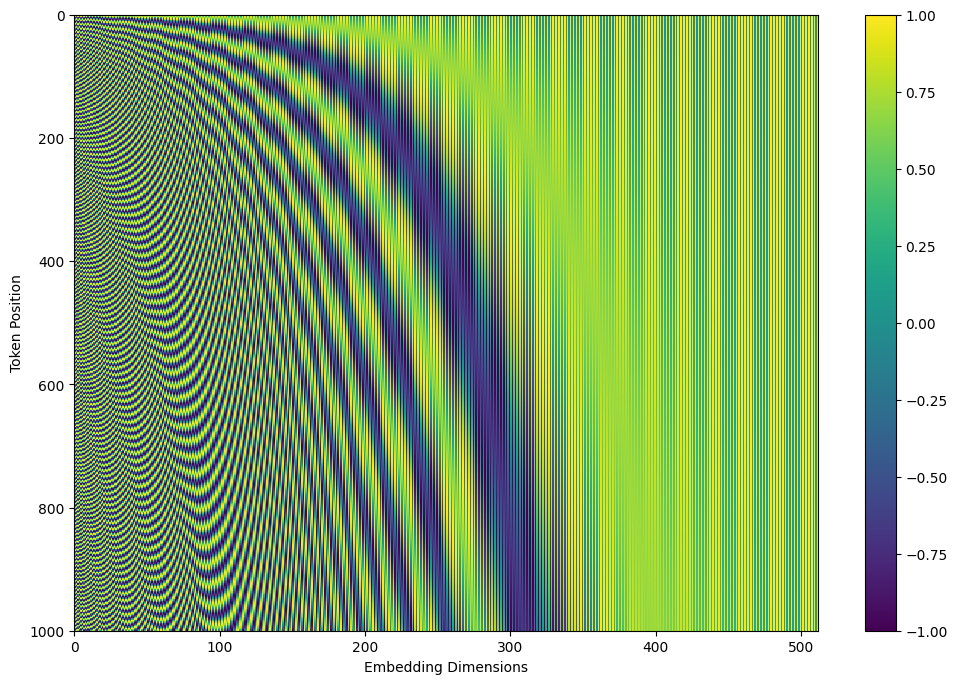

In [ ]:
tokens = 1000
dimensions = 512

pe = PositionalEncoding(dimensions, 0)
pos_encoding = pe.forward(torch.zeros(1, tokens, dimensions))

pos_encodings = pos_encoding.reshape([1, tokens, dimensions]).numpy()
print(pos_encoding.shape)

plt.figure(figsize=(12,8))
plt.pcolormesh(pos_encoding[0], cmap='viridis')
plt.xlabel('Embedding Dimensions')
plt.xlim((0, dimensions))
plt.ylim((tokens,0))
plt.ylabel('Token Position')
plt.colorbar()
plt.show()

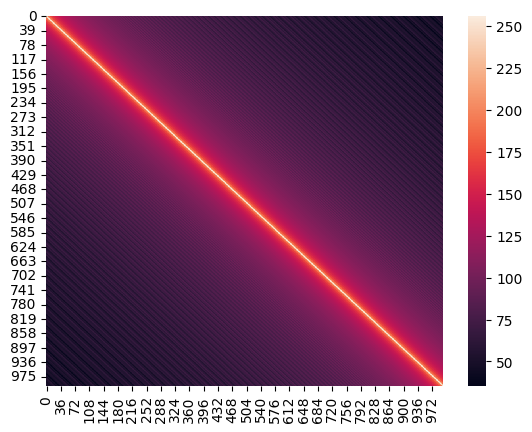

In [ ]:
dot_matrix = pos_encodings[0] @ pos_encodings[0].T
sns.heatmap(dot_matrix)
plt.show()

<center>
<div>
<img src="https://sun9-17.userapi.com/impg/gefaYRAxg9-Z_FeGLtEXsecv6BAu30fzBaOF2A/BcfIbgrYOY4.jpg?size=1120x326&quality=96&sign=7a8e392e7cb771c71acd08025dd80ea9&type=album", width="1000">
</div>

Почитать про позиционное кодирование можно тут [cite](https://arxiv.org/pdf/2010.04903.pdf)

## `3.5 Собираем модель целиком`

<!-- > Here we define a function from hyperparameters to a full model. -->

> Теперь напишем функцию, возвращающую готовую модель по гиперпараметрам

In [ ]:
def make_model(
    src_vocab, tgt_vocab, N=6, d_model=512, d_ff=2048, h=8, dropout=0.1
):
    "Helper: Construct a model from hyperparameters."
    c = copy.deepcopy
    attn = MultiHeadedAttention(h, d_model)
    ff = PositionwiseFeedForward(d_model, d_ff, dropout)
    position = PositionalEncoding(d_model, dropout)
    model = EncoderDecoder(
        Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),
        Decoder(DecoderLayer(d_model, c(attn), c(attn), c(ff), dropout), N),
        nn.Sequential(Embeddings(d_model, src_vocab), c(position)),
        nn.Sequential(Embeddings(d_model, tgt_vocab), c(position)),
        Generator(d_model, tgt_vocab),
    )

    # This was important from their code.
    # Initialize parameters with Glorot / fan_avg.
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)
    return model

Конечно, написание трансформера с нуля – очень полезный навык, однако, в PyTorch есть готовые блоки для этого:

`nn.Transformer` - готовая модель Transformer \\
`nn.TransformerEncoder` - стэк из N блоков кодировщика \\
`nn.TransformerDecoder` - стэк из N блоков декодировщика \\
`nn.TransformerEncoderLayer` – один блок кодировщика с MHSA и FCN \\
`nn.TransformerDecoderLayer` – один блок кодировщика с MHSA, MHCA и FCN \\

https://pytorch.org/docs/stable/nn.html#transformer-layers

## `3.6 Тестируем forward:`

<!-- > Here we make a forward step to generate a prediction of the
model. We try to use our transformer to memorize the input. As you
will see the output is randomly generated due to the fact that the
model is not trained yet. In the next tutorial we will build the
training function and try to train our model to memorize the numbers
from 1 to 10. -->

> Здесь мы делаем шаг вперед, чтобы сгенерировать прогноз модели. Мы пытаемся использовать наш кодировщик для запоминания ввода. Как вы увидите, выходные данные генерируются случайным образом из-за того, что модель еще не обучена. В следующей секции мы создадим синтетическую обучающую выборку и попробуем обучить наш трансформер запоминать числа от 1 до 10.

In [ ]:
def inference_test():
    test_model = make_model(11, 11, 2)
    test_model.eval()
    src = torch.LongTensor([[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]])
    src_mask = torch.ones(1, 1, 10)

    memory = test_model.encode(src, src_mask)
    ys = torch.zeros(1, 1).type_as(src)

    for i in range(9):
        out = test_model.decode(
            memory, src_mask, ys, subsequent_mask(ys.size(1)).type_as(src.data)
        )
        prob = test_model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.data[0]
        ys = torch.cat(
            [ys, torch.empty(1, 1).type_as(src.data).fill_(next_word)], dim=1
        )

    print("Example Untrained Model Prediction:", ys)


def run_tests():
    for _ in range(10):
        inference_test()


show_example(run_tests)

Example Untrained Model Prediction: tensor([[0, 7, 4, 7, 4, 7, 4, 7, 7, 7]])
Example Untrained Model Prediction: tensor([[ 0,  9, 10,  7, 10,  7, 10,  7, 10,  7]])
Example Untrained Model Prediction: tensor([[0, 4, 4, 4, 4, 4, 4, 4, 4, 4]])
Example Untrained Model Prediction: tensor([[0, 3, 3, 3, 3, 3, 3, 3, 3, 3]])
Example Untrained Model Prediction: tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
Example Untrained Model Prediction: tensor([[0, 3, 0, 3, 4, 0, 3, 0, 9, 0]])
Example Untrained Model Prediction: tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
Example Untrained Model Prediction: tensor([[ 0, 10,  9,  0,  9,  0,  9,  0, 10,  9]])
Example Untrained Model Prediction: tensor([[0, 5, 3, 4, 0, 3, 4, 3, 4, 0]])
Example Untrained Model Prediction: tensor([[ 0,  7,  9,  6,  9,  3,  9, 10,  7,  9]])


# `4. Процесс обучения трансформеров`

## `4.1 Вспомогательные функии`

<!-- This section describes the training regime for our models. -->
В этой секции опишем процедуру обучения трансформера.
Ниже описаны вспомогательные функции для обучения.

### Batches and Masking

In [ ]:
class Batch:
    """Object for holding a batch of data with mask during training."""

    def __init__(self, src, tgt=None, pad=2):  # 2 = <blank>
        self.src = src
        self.src_mask = (src != pad).unsqueeze(-2)
        if tgt is not None:
            self.tgt = tgt[:, :-1]
            self.tgt_y = tgt[:, 1:]
            self.tgt_mask = self.make_std_mask(self.tgt, pad)
            self.ntokens = (self.tgt_y != pad).data.sum()

    @staticmethod
    def make_std_mask(tgt, pad):
        "Create a mask to hide padding and future words."
        tgt_mask = (tgt != pad).unsqueeze(-2)
        tgt_mask = tgt_mask & subsequent_mask(tgt.size(-1)).type_as(
            tgt_mask.data
        )
        return tgt_mask

### Training Loop

In [ ]:
class TrainState:
    """Track number of steps, examples, and tokens processed"""

    step: int = 0  # Steps in the current epoch
    accum_step: int = 0  # Number of gradient accumulation steps
    samples: int = 0  # total # of examples used
    tokens: int = 0  # total # of tokens processed

In [ ]:
def run_epoch(
    data_iter,
    model,
    loss_compute,
    optimizer,
    scheduler,
    mode="train",
    accum_iter=1,
    train_state=TrainState(),
):
    """Train a single epoch"""
    start = time.time()
    total_tokens = 0
    total_loss = 0
    tokens = 0
    n_accum = 0
    for i, batch in enumerate(data_iter):
        out = model.forward(
            batch.src, batch.tgt, batch.src_mask, batch.tgt_mask
        )
        loss, loss_node = loss_compute(out, batch.tgt_y, batch.ntokens)
        # loss_node = loss_node / accum_iter
        if mode == "train" or mode == "train+log":
            loss_node.backward()
            train_state.step += 1
            train_state.samples += batch.src.shape[0]
            train_state.tokens += batch.ntokens
            if i % accum_iter == 0:
                optimizer.step()
                optimizer.zero_grad(set_to_none=True)
                n_accum += 1
                train_state.accum_step += 1
            scheduler.step()

        total_loss += loss
        total_tokens += batch.ntokens
        tokens += batch.ntokens
        if i % 40 == 1 and (mode == "train" or mode == "train+log"):
            lr = optimizer.param_groups[0]["lr"]
            elapsed = time.time() - start
            print(
                (
                    " | Loss: %6.2f "
                    + "| Tokens / Sec: %7.1f | Learning Rate: %6.1e"
                )
                % (loss / batch.ntokens, tokens / elapsed, lr)
            )
            start = time.time()
            tokens = 0
        del loss
        del loss_node
    return total_loss / total_tokens, train_state

## `4.2 Обучающая выборка`

<!-- We trained on the standard WMT 2014 English-German dataset
consisting of about 4.5 million sentence pairs.  Sentences were
encoded using byte-pair encoding, which has a shared source-target
vocabulary of about 37000 tokens. For English-French, we used the
significantly larger WMT 2014 English-French dataset consisting of
36M sentences and split tokens into a 32000 word-piece vocabulary.


Sentence pairs were batched together by approximate sequence length.
Each training batch contained a set of sentence pairs containing
approximately 25000 source tokens and 25000 target tokens. -->

В работе Attention is all you need обучение производилось на стандартном англо-немецком наборе данных WMT 2014, состоящем примерно из 4,5 миллионов пар предложений. Предложения были закодированы с использованием byte-pair encoding. Получившийся словарь имеет около 37000 токенов. Также модель обучалась на англо-французском датасете. Был использован значительно больший англо-французский набор данных WMT 2014, состоящий из 36 миллионов предложений и разделенных токенов на словарь из 32000 слов.

Пары предложений были объединены в батчи по приблизительной длине последовательности. Каждый батч состоял из набора пар предложений, содержащих примерно 25000 исходных и 25000 целевых токенов.

## `4.3 Hardware and Schedule`

<!-- We trained our models on one machine with 8 NVIDIA P100 GPUs.  For
our base models using the hyperparameters described throughout the
paper, each training step took about 0.4 seconds.  We trained the
base models for a total of 100,000 steps or 12 hours. For our big
models, step time was 1.0 seconds.  The big models were trained for
300,000 steps (3.5 days). -->

Модели обучались на одной машине с 8 графическими процессорами NVIDIA P100. Для base-моделей, использующих описанные в статье гиперпараметры, каждый шаг обучения занимал около 0,4 секунд. Они обучались в общей сложности 100 000 шагов или 12 часов. Для больших моделей время шага составляло 1,0 секунды. Large-модели были обучены за 300 000 шагов (3,5 дня).

## `4.4 Optimizer`

<!-- We used the Adam optimizer [(cite)](https://arxiv.org/abs/1412.6980)
with $\beta_1=0.9$, $\beta_2=0.98$ and $\epsilon=10^{-9}$.  We
varied the learning rate over the course of training, according to
the formula: -->
В статье использовался Adam [(cite)](https://arxiv.org/abs/1412.6980) с параметрами $\beta_1=0.9$, $\beta_2=0.98$ и $\epsilon=10^{-9}$. Learning rate варьировался по следующей формуле:

$$
lrate = d_{\text{model}}^{-0.5} \cdot
  \min({step\_num}^{-0.5},
    {step\_num} \cdot {warmup\_steps}^{-1.5})
$$

<!-- This corresponds to increasing the learning rate linearly for the
first $warmup\_steps$ training steps, and decreasing it thereafter
proportionally to the inverse square root of the step number.  We
used $warmup\_steps=4000$. -->

Это соответствует линейному увеличению learning rate для первых $warmup\_steps$ шагов. Далее learning rate уменьшается пропорционально обратному квадратному корню из номера шага. Использовался $warmup\_steps=4000$.

In [ ]:
def rate(step, model_size, factor, warmup):
    """
    we have to default the step to 1 for LambdaLR function
    to avoid zero raising to negative power.
    """
    if step == 0:
        step = 1
    return factor * (
        model_size ** (-0.5) * min(step ** (-0.5), step * warmup ** (-1.5))
    )

In [ ]:
def example_learning_schedule():
    opts = [
        [512, 1, 4000],  # example 1
        [512, 1, 8000],  # example 2
        [256, 1, 4000],  # example 3
    ]

    dummy_model = torch.nn.Linear(1, 1)
    learning_rates = []

    # we have 3 examples in opts list.
    for idx, example in enumerate(opts):
        # run 20000 epoch for each example
        optimizer = torch.optim.Adam(
            dummy_model.parameters(), lr=1, betas=(0.9, 0.98), eps=1e-9
        )
        lr_scheduler = LambdaLR(
            optimizer=optimizer, lr_lambda=lambda step: rate(step, *example)
        )
        tmp = []
        # take 20K dummy training steps, save the learning rate at each step
        for step in range(20000):
            tmp.append(optimizer.param_groups[0]["lr"])
            optimizer.step()
            lr_scheduler.step()
        learning_rates.append(tmp)

    learning_rates = torch.tensor(learning_rates)

    # Enable altair to handle more than 5000 rows
    alt.data_transformers.disable_max_rows()

    opts_data = pd.concat(
        [
            pd.DataFrame(
                {
                    "Learning Rate": learning_rates[warmup_idx, :],
                    "model_size:warmup": ["512:4000", "512:8000", "256:4000"][
                        warmup_idx
                    ],
                    "step": range(20000),
                }
            )
            for warmup_idx in [0, 1, 2]
        ]
    )

    return (
        alt.Chart(opts_data)
        .mark_line()
        .properties(width=600)
        .encode(x="step", y="Learning Rate", color="model_size:warmup:N")
        .interactive()
    )


example_learning_schedule()

alt.Chart(...)

## `4.5 Регуляризация`

### Label Smoothing

<!-- During training, we employed label smoothing of value
$\epsilon_{ls}=0.1$ [(cite)](https://arxiv.org/abs/1512.00567).
This hurts perplexity, as the model learns to be more unsure, but
improves accuracy and BLEU score. -->

Во время обучения мы используем label smoothing со значением $\epsilon_{ls}=0.1$ [(cite)](https://arxiv.org/abs/1512.00567). Это уменьшает перплексию, поскольку модель учится быть более неуверенной, но при этом повышается точность и значение метрики BLEU на реальных данных.


<!-- > We implement label smoothing using the KL div loss. Instead of
> using a one-hot target distribution, we create a distribution that
> has `confidence` of the correct word and the rest of the
> `smoothing` mass distributed throughout the vocabulary. -->

> Реализуем label smoothing с помощью `nn.KLDivLoss`.

In [ ]:
class LabelSmoothing(nn.Module):
    "Implement label smoothing."

    def __init__(self, size, padding_idx, smoothing=0.0):
        super(LabelSmoothing, self).__init__()
        self.criterion = nn.KLDivLoss(reduction="sum")
        self.padding_idx = padding_idx
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.size = size
        self.true_dist = None

    def forward(self, x, target):
        assert x.size(1) == self.size
        true_dist = x.data.clone()
        true_dist.fill_(self.smoothing / (self.size - 2))
        true_dist.scatter_(dim=1, index=target.data.unsqueeze(1), source=self.confidence)
        true_dist[:, self.padding_idx] = 0
        mask = torch.nonzero(target.data == self.padding_idx)
        if mask.dim() > 0:
            true_dist.index_fill_(0, mask.squeeze(), 0.0)
        self.true_dist = true_dist
        return self.criterion(x, true_dist.clone().detach())


<!-- > Label smoothing actually starts to penalize the model if it gets
> very confident about a given choice. -->

> Label smoothing фактически начинает наказывать модель, если она становится очень уверенной в своих предсказаниях.

$$
L' = \sum_{i=1}^{n} \big[(1-\epsilon_{ls})KL(p, q_{\theta}) + \epsilon_{ls}KL(u, q_{\theta})\big] \\
u \sim U([1 \dots K])
$$

# `5. Синтетический пример`

<!-- > We can begin by trying out a simple copy-task. Given a random set
> of input symbols from a small vocabulary, the goal is to generate
> back those same symbols. -->

> Давайте попробуем обучить нашу модель решать простую задачу. Пусть это будет задача копирования последовательности. Принимая на вход случайный набор символов из небольшого словаря, модель должна сгенерировать обратно те же самые символы.

## `5.1 Генерируем данные`

In [ ]:
def data_gen(V, batch_size, nbatches):
    "Generate random data for a src-tgt copy task."
    for i in range(nbatches):
        data = torch.randint(1, V, size=(batch_size, 10))
        data[:, 0] = 1
        src = data.requires_grad_(False).clone().detach()
        tgt = data.requires_grad_(False).clone().detach()
        # tgt = torch.flip(data, dims=[1]).requires_grad_(False).clone().detach()
        yield Batch(src, tgt, 0)

## `5.2 Loss Computation`

In [ ]:
class SimpleLossCompute:
    "A simple loss compute and train function."

    def __init__(self, generator, criterion):
        self.generator = generator
        self.criterion = criterion

    def __call__(self, x, y, norm):
        x = self.generator(x)
        sloss = (
            self.criterion(
                x.contiguous().view(-1, x.size(-1)), y.contiguous().view(-1)
            )
            / norm
        )
        return sloss.data * norm, sloss

## `5.3 Greedy Decoding`

<!-- > This code predicts a translation using greedy decoding for simplicity. -->

> Будем генерировать предсказание жадным образом.

In [ ]:
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    memory = model.encode(src, src_mask)
    ys = torch.zeros(1, 1).fill_(start_symbol).type_as(src.data)
    for i in range(max_len - 1):
        out = model.decode(
            memory, src_mask, ys, subsequent_mask(ys.size(1)).type_as(src.data)
        )
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.data[0]
        ys = torch.cat(
            [ys, torch.zeros(1, 1).type_as(src.data).fill_(next_word)], dim=1
        )
    return ys

Другой способ получить предсказание – Beam Search [cite:](https://towardsdatascience.com/foundations-of-nlp-explained-visually-beam-search-how-it-works-1586b9849a24)

In [ ]:
# Train the simple copy task.


def train_simple_model(n_epochs, **model_params):
    V = 11
    criterion = LabelSmoothing(size=V, padding_idx=0, smoothing=0.0)
    # model = make_model(V, V, N=1, h=1)
    model = make_model(V, V, **model_params)

    optimizer = torch.optim.Adam(
        model.parameters(), lr=0.5, betas=(0.9, 0.98), eps=1e-9
    )
    lr_scheduler = LambdaLR(
        optimizer=optimizer,
        lr_lambda=lambda step: rate(
            step, model_size=model.src_embed[0].d_model, factor=1.0, warmup=400
        ),
    )

    batch_size = 80
    ts = TrainState()
    for epoch in range(n_epochs):
        print(f'Epoch {epoch}', end='')
        model.train()
        run_epoch(
            data_gen(V, batch_size, 20),
            model,
            SimpleLossCompute(model.generator, criterion),
            optimizer,
            lr_scheduler,
            mode="train",
        )
        model.eval()
        run_epoch(
            data_gen(V, batch_size, 5),
            model,
            SimpleLossCompute(model.generator, criterion),
            DummyOptimizer(),
            DummyScheduler(),
            mode="eval",
        )

    model.eval()
    return model

In [ ]:
model = train_simple_model(10, N=2, h=1)

Epoch 0 | Loss:   3.42 | Tokens / Sec:   206.6 | Learning Rate: 5.5e-06
Epoch 1 | Loss:   2.31 | Tokens / Sec:   679.1 | Learning Rate: 6.1e-05
Epoch 2 | Loss:   1.83 | Tokens / Sec:   340.1 | Learning Rate: 1.2e-04
Epoch 3 | Loss:   1.27 | Tokens / Sec:   647.5 | Learning Rate: 1.7e-04
Epoch 4 | Loss:   0.89 | Tokens / Sec:   667.3 | Learning Rate: 2.3e-04
Epoch 5 | Loss:   0.48 | Tokens / Sec:   730.1 | Learning Rate: 2.8e-04
Epoch 6 | Loss:   0.41 | Tokens / Sec:   321.5 | Learning Rate: 3.4e-04
Epoch 7 | Loss:   0.27 | Tokens / Sec:   727.4 | Learning Rate: 3.9e-04
Epoch 8 | Loss:   0.26 | Tokens / Sec:   676.0 | Learning Rate: 4.5e-04
Epoch 9 | Loss:   0.26 | Tokens / Sec:   608.8 | Learning Rate: 5.0e-04


## `5.4 Attention Visualization`

Давайте посмотрим на attention-матрицы, которые выучила наша модель.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
def get_encoder_self(model, layer):
    return model.encoder.layers[layer].self_attn.attn


def get_decoder_self(model, layer):
    return model.decoder.layers[layer].self_attn.attn


def get_decoder_src(model, layer):
    return model.decoder.layers[layer].src_attn.attn

In [ ]:
src = torch.LongTensor([[1, 3, 4, 5, 6, 7, 8, 9, 8, 7, 6, 5]])
print('sourse:\t', src)
# print('target:\t', torch.flip(src, dims=[1]))
max_len = src.shape[1]
src_mask = torch.ones(1, 1, max_len)
print('pred:\t', greedy_decode(model, src, src_mask, max_len=max_len, start_symbol=1))

sourse:	 tensor([[1, 3, 4, 5, 6, 7, 8, 9, 8, 7, 6, 5]])
pred:	 tensor([[1, 3, 4, 5, 6, 7, 8, 9, 8, 7, 6, 7]])


In [ ]:
get_encoder_self(model, 0).size()

torch.Size([1, 1, 12, 12])

In [ ]:
get_decoder_src(model, 0).size()

torch.Size([1, 1, 11, 12])

In [ ]:
get_decoder_self(model, 0).size()

torch.Size([1, 1, 11, 11])

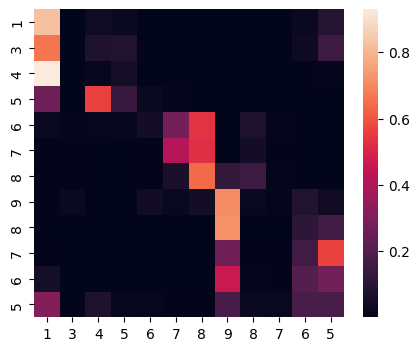

In [ ]:
# @title Encoder Self-Attention
fig, ax = plt.subplots(figsize=(5, 4))
sns.heatmap(get_encoder_self(model, 1)[0][0].data)
ax.set_xticklabels(src[0].tolist())
ax.set_yticklabels(src[0].tolist())
plt.show()

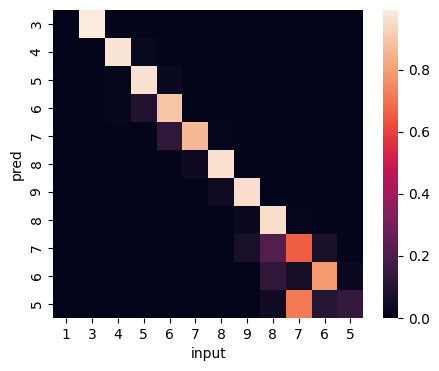

In [ ]:
# @title Decoder Cross-Attention
fig, ax = plt.subplots(figsize=(5, 4))
sns.heatmap(get_decoder_src(model, 0)[0][0].data)
ax.set_xticklabels(src[0].tolist())
ax.set_xlabel('input')
ax.set_yticklabels(src[0, 1:].tolist())
ax.set_ylabel('pred')
plt.show()

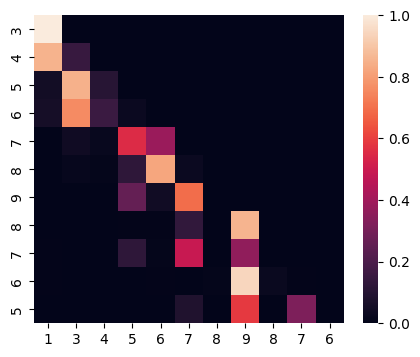

In [ ]:
# @title Decoder Self-Attention
fig, ax = plt.subplots(figsize=(5, 4))
sns.heatmap(get_decoder_self(model, 0)[0][0].data)
ax.set_xticklabels(src[0, 0:-1].tolist())
ax.set_yticklabels(src[0, 1:].tolist())
plt.show()

# `6. Материалы по теме`

1. http://nlp.seas.harvard.edu/annotated-transformer
2. https://jalammar.github.io/illustrated-transformer/
3. Лекция К.В. Воронцова [link](https://www.youtube.com/watch?v=KhMweP00S44)
4. https://web.stanford.edu/class/cs25/
5. https://lena-voita.github.io/nlp_course.html#preview_seq2seq_attn



# `7. Дополнительно`

## Real Data

> Now we consider a real-world example using the Multi30k
> German-English Translation task. This task is much smaller than
> the WMT task considered in the paper, but it illustrates the whole
> system. We also show how to use multi-gpu processing to make it
> really fast.

## Data Loading

> We will load the dataset using torchtext and spacy for
> tokenization.

In [ ]:
# Load spacy tokenizer models, download them if they haven't been
# downloaded already


def load_tokenizers():

    try:
        spacy_de = spacy.load("de_core_news_sm")
    except IOError:
        os.system("python -m spacy download de_core_news_sm")
        spacy_de = spacy.load("de_core_news_sm")

    try:
        spacy_en = spacy.load("en_core_web_sm")
    except IOError:
        os.system("python -m spacy download en_core_web_sm")
        spacy_en = spacy.load("en_core_web_sm")

    return spacy_de, spacy_en

In [ ]:
def tokenize(text, tokenizer):
    return [tok.text for tok in tokenizer.tokenizer(text)]


def yield_tokens(data_iter, tokenizer, index):
    for from_to_tuple in data_iter:
        yield tokenizer(from_to_tuple[index])

In [ ]:


def build_vocabulary(spacy_de, spacy_en):
    def tokenize_de(text):
        return tokenize(text, spacy_de)

    def tokenize_en(text):
        return tokenize(text, spacy_en)

    print("Building German Vocabulary ...")
    train, val, test = datasets.Multi30k(language_pair=("de", "en"))
    vocab_src = build_vocab_from_iterator(
        yield_tokens(train + val + test, tokenize_de, index=0),
        min_freq=2,
        specials=["<s>", "</s>", "<blank>", "<unk>"],
    )

    print("Building English Vocabulary ...")
    train, val, test = datasets.Multi30k(language_pair=("de", "en"))
    vocab_tgt = build_vocab_from_iterator(
        yield_tokens(train + val + test, tokenize_en, index=1),
        min_freq=2,
        specials=["<s>", "</s>", "<blank>", "<unk>"],
    )

    vocab_src.set_default_index(vocab_src["<unk>"])
    vocab_tgt.set_default_index(vocab_tgt["<unk>"])

    return vocab_src, vocab_tgt


def load_vocab(spacy_de, spacy_en):
    if not exists("vocab.pt"):
        vocab_src, vocab_tgt = build_vocabulary(spacy_de, spacy_en)
        torch.save((vocab_src, vocab_tgt), "vocab.pt")
    else:
        vocab_src, vocab_tgt = torch.load("vocab.pt")
    print("Finished.\nVocabulary sizes:")
    print(len(vocab_src))
    print(len(vocab_tgt))
    return vocab_src, vocab_tgt


if is_interactive_notebook():
    # global variables used later in the script
    spacy_de, spacy_en = show_example(load_tokenizers)
    vocab_src, vocab_tgt = show_example(load_vocab, args=[spacy_de, spacy_en])

Finished.
Vocabulary sizes:
59981
36745



> Batching matters a ton for speed. We want to have very evenly
> divided batches, with absolutely minimal padding. To do this we
> have to hack a bit around the default torchtext batching. This
> code patches their default batching to make sure we search over
> enough sentences to find tight batches.

## Iterators

In [ ]:
def collate_batch(
    batch,
    src_pipeline,
    tgt_pipeline,
    src_vocab,
    tgt_vocab,
    device,
    max_padding=128,
    pad_id=2,
):
    bs_id = torch.tensor([0], device=device)  # <s> token id
    eos_id = torch.tensor([1], device=device)  # </s> token id
    src_list, tgt_list = [], []
    for (_src, _tgt) in batch:
        processed_src = torch.cat(
            [
                bs_id,
                torch.tensor(
                    src_vocab(src_pipeline(_src)),
                    dtype=torch.int64,
                    device=device,
                ),
                eos_id,
            ],
            0,
        )
        processed_tgt = torch.cat(
            [
                bs_id,
                torch.tensor(
                    tgt_vocab(tgt_pipeline(_tgt)),
                    dtype=torch.int64,
                    device=device,
                ),
                eos_id,
            ],
            0,
        )
        src_list.append(
            # warning - overwrites values for negative values of padding - len
            pad(
                processed_src,
                (
                    0,
                    max_padding - len(processed_src),
                ),
                value=pad_id,
            )
        )
        tgt_list.append(
            pad(
                processed_tgt,
                (0, max_padding - len(processed_tgt)),
                value=pad_id,
            )
        )

    src = torch.stack(src_list)
    tgt = torch.stack(tgt_list)
    return (src, tgt)

In [ ]:
def create_dataloaders(
    device,
    vocab_src,
    vocab_tgt,
    spacy_de,
    spacy_en,
    batch_size=12000,
    max_padding=128,
    is_distributed=True,
):
    # def create_dataloaders(batch_size=12000):
    def tokenize_de(text):
        return tokenize(text, spacy_de)

    def tokenize_en(text):
        return tokenize(text, spacy_en)

    def collate_fn(batch):
        return collate_batch(
            batch,
            tokenize_de,
            tokenize_en,
            vocab_src,
            vocab_tgt,
            device,
            max_padding=max_padding,
            pad_id=vocab_src.get_stoi()["<blank>"],
        )

    train_iter, valid_iter, test_iter = datasets.Multi30k(
        language_pair=("de", "en")
    )

    train_iter_map = to_map_style_dataset(
        train_iter
    )  # DistributedSampler needs a dataset len()
    train_sampler = (
        DistributedSampler(train_iter_map) if is_distributed else None
    )
    valid_iter_map = to_map_style_dataset(valid_iter)
    valid_sampler = (
        DistributedSampler(valid_iter_map) if is_distributed else None
    )

    train_dataloader = DataLoader(
        train_iter_map,
        batch_size=batch_size,
        shuffle=(train_sampler is None),
        sampler=train_sampler,
        collate_fn=collate_fn,
    )
    valid_dataloader = DataLoader(
        valid_iter_map,
        batch_size=batch_size,
        shuffle=(valid_sampler is None),
        sampler=valid_sampler,
        collate_fn=collate_fn,
    )
    return train_dataloader, valid_dataloader

## Training the System

In [ ]:
def train_worker(
    gpu,
    ngpus_per_node,
    vocab_src,
    vocab_tgt,
    spacy_de,
    spacy_en,
    config,
    is_distributed=False,
):
    print(f"Train worker process using GPU: {gpu} for training", flush=True)
    torch.cuda.set_device(gpu)

    pad_idx = vocab_tgt["<blank>"]
    d_model = 512
    model = make_model(len(vocab_src), len(vocab_tgt), N=6)
    model.cuda(gpu)
    module = model
    is_main_process = True
    if is_distributed:
        dist.init_process_group(
            "nccl", init_method="env://", rank=gpu, world_size=ngpus_per_node
        )
        model = DDP(model, device_ids=[gpu])
        module = model.module
        is_main_process = gpu == 0

    criterion = LabelSmoothing(
        size=len(vocab_tgt), padding_idx=pad_idx, smoothing=0.1
    )
    criterion.cuda(gpu)

    train_dataloader, valid_dataloader = create_dataloaders(
        gpu,
        vocab_src,
        vocab_tgt,
        spacy_de,
        spacy_en,
        batch_size=config["batch_size"] // ngpus_per_node,
        max_padding=config["max_padding"],
        is_distributed=is_distributed,
    )

    optimizer = torch.optim.Adam(
        model.parameters(), lr=config["base_lr"], betas=(0.9, 0.98), eps=1e-9
    )
    lr_scheduler = LambdaLR(
        optimizer=optimizer,
        lr_lambda=lambda step: rate(
            step, d_model, factor=1, warmup=config["warmup"]
        ),
    )
    train_state = TrainState()

    for epoch in range(config["num_epochs"]):
        if is_distributed:
            train_dataloader.sampler.set_epoch(epoch)
            valid_dataloader.sampler.set_epoch(epoch)

        model.train()
        print(f"[GPU{gpu}] Epoch {epoch} Training ====", flush=True)
        _, train_state = run_epoch(
            (Batch(b[0], b[1], pad_idx) for b in train_dataloader),
            model,
            SimpleLossCompute(module.generator, criterion),
            optimizer,
            lr_scheduler,
            mode="train+log",
            accum_iter=config["accum_iter"],
            train_state=train_state,
        )

        GPUtil.showUtilization()
        if is_main_process:
            file_path = "%s%.2d.pt" % (config["file_prefix"], epoch)
            torch.save(module.state_dict(), file_path)
        torch.cuda.empty_cache()

        print(f"[GPU{gpu}] Epoch {epoch} Validation ====", flush=True)
        model.eval()
        sloss = run_epoch(
            (Batch(b[0], b[1], pad_idx) for b in valid_dataloader),
            model,
            SimpleLossCompute(module.generator, criterion),
            DummyOptimizer(),
            DummyScheduler(),
            mode="eval",
        )
        print(sloss)
        torch.cuda.empty_cache()

    if is_main_process:
        file_path = "%sfinal.pt" % config["file_prefix"]
        torch.save(module.state_dict(), file_path)

In [ ]:
def train_distributed_model(vocab_src, vocab_tgt, spacy_de, spacy_en, config):
    from the_annotated_transformer import train_worker

    ngpus = torch.cuda.device_count()
    os.environ["MASTER_ADDR"] = "localhost"
    os.environ["MASTER_PORT"] = "12356"
    print(f"Number of GPUs detected: {ngpus}")
    print("Spawning training processes ...")
    mp.spawn(
        train_worker,
        nprocs=ngpus,
        args=(ngpus, vocab_src, vocab_tgt, spacy_de, spacy_en, config, True),
    )


def train_model(vocab_src, vocab_tgt, spacy_de, spacy_en, config):
    if config["distributed"]:
        train_distributed_model(
            vocab_src, vocab_tgt, spacy_de, spacy_en, config
        )
    else:
        train_worker(
            0, 1, vocab_src, vocab_tgt, spacy_de, spacy_en, config, False
        )


def load_trained_model():
    config = {
        "batch_size": 32,
        "distributed": False,
        "num_epochs": 8,
        "accum_iter": 10,
        "base_lr": 1.0,
        "max_padding": 72,
        "warmup": 3000,
        "file_prefix": "multi30k_model_",
    }
    model_path = "multi30k_model_final.pt"
    if not exists(model_path):
        train_model(vocab_src, vocab_tgt, spacy_de, spacy_en, config)

    model = make_model(len(vocab_src), len(vocab_tgt), N=6)
    model.load_state_dict(torch.load("multi30k_model_final.pt"))
    return model


if is_interactive_notebook():
    model = load_trained_model()


> Once trained we can decode the model to produce a set of
> translations. Here we simply translate the first sentence in the
> validation set. This dataset is pretty small so the translations
> with greedy search are reasonably accurate.

## BPE, Search, Averaging


> So this mostly covers the transformer model itself. There are four
> aspects that we didn't cover explicitly. We also have all these
> additional features implemented in
> [OpenNMT-py](https://github.com/opennmt/opennmt-py).




> 1) BPE/ Word-piece: We can use a library to first preprocess the
> data into subword units. See Rico Sennrich's
> [subword-nmt](https://github.com/rsennrich/subword-nmt)
> implementation. These models will transform the training data to
> look like this:

▁Die ▁Protokoll datei ▁kann ▁ heimlich ▁per ▁E - Mail ▁oder ▁FTP
▁an ▁einen ▁bestimmte n ▁Empfänger ▁gesendet ▁werden .


> 2) Shared Embeddings: When using BPE with shared vocabulary we can
> share the same weight vectors between the source / target /
> generator. See the [(cite)](https://arxiv.org/abs/1608.05859) for
> details. To add this to the model simply do this:

In [ ]:
if False:
    model.src_embed[0].lut.weight = model.tgt_embeddings[0].lut.weight
    model.generator.lut.weight = model.tgt_embed[0].lut.weight


> 3) Beam Search: This is a bit too complicated to cover here. See the
> [OpenNMT-py](https://github.com/OpenNMT/OpenNMT-py/)
> for a pytorch implementation.
>



> 4) Model Averaging: The paper averages the last k checkpoints to
> create an ensembling effect. We can do this after the fact if we
> have a bunch of models:

In [ ]:
def average(model, models):
    "Average models into model"
    for ps in zip(*[m.params() for m in [model] + models]):
        ps[0].copy_(torch.sum(*ps[1:]) / len(ps[1:]))

## Results

On the WMT 2014 English-to-German translation task, the big
transformer model (Transformer (big) in Table 2) outperforms the
best previously reported models (including ensembles) by more than
2.0 BLEU, establishing a new state-of-the-art BLEU score of
28.4. The configuration of this model is listed in the bottom line
of Table 3. Training took 3.5 days on 8 P100 GPUs. Even our base
model surpasses all previously published models and ensembles, at a
fraction of the training cost of any of the competitive models.

On the WMT 2014 English-to-French translation task, our big model
achieves a BLEU score of 41.0, outperforming all of the previously
published single models, at less than 1/4 the training cost of the
previous state-of-the-art model. The Transformer (big) model trained
for English-to-French used dropout rate Pdrop = 0.1, instead of 0.3.


![](https://github.com/harvardnlp/annotated-transformer/blob/master/images/results.png?raw=1)



> With the addtional extensions in the last section, the OpenNMT-py
> replication gets to 26.9 on EN-DE WMT. Here I have loaded in those
> parameters to our reimplemenation.

In [ ]:
# Load data and model for output checks

In [ ]:
def check_outputs(
    valid_dataloader,
    model,
    vocab_src,
    vocab_tgt,
    n_examples=15,
    pad_idx=2,
    eos_string="</s>",
):
    results = [()] * n_examples
    for idx in range(n_examples):
        print("\nExample %d ========\n" % idx)
        b = next(iter(valid_dataloader))
        rb = Batch(b[0], b[1], pad_idx)
        greedy_decode(model, rb.src, rb.src_mask, 64, 0)[0]

        src_tokens = [
            vocab_src.get_itos()[x] for x in rb.src[0] if x != pad_idx
        ]
        tgt_tokens = [
            vocab_tgt.get_itos()[x] for x in rb.tgt[0] if x != pad_idx
        ]

        print(
            "Source Text (Input)        : "
            + " ".join(src_tokens).replace("\n", "")
        )
        print(
            "Target Text (Ground Truth) : "
            + " ".join(tgt_tokens).replace("\n", "")
        )
        model_out = greedy_decode(model, rb.src, rb.src_mask, 72, 0)[0]
        model_txt = (
            " ".join(
                [vocab_tgt.get_itos()[x] for x in model_out if x != pad_idx]
            ).split(eos_string, 1)[0]
            + eos_string
        )
        print("Model Output               : " + model_txt.replace("\n", ""))
        results[idx] = (rb, src_tokens, tgt_tokens, model_out, model_txt)
    return results


def run_model_example(n_examples=5):
    global vocab_src, vocab_tgt, spacy_de, spacy_en

    print("Preparing Data ...")
    _, valid_dataloader = create_dataloaders(
        torch.device("cpu"),
        vocab_src,
        vocab_tgt,
        spacy_de,
        spacy_en,
        batch_size=1,
        is_distributed=False,
    )

    print("Loading Trained Model ...")

    model = make_model(len(vocab_src), len(vocab_tgt), N=6)
    model.load_state_dict(
        torch.load("multi30k_model_final.pt", map_location=torch.device("cpu"))
    )

    print("Checking Model Outputs:")
    example_data = check_outputs(
        valid_dataloader, model, vocab_src, vocab_tgt, n_examples=n_examples
    )
    return model, example_data


# execute_example(run_model_example)

## Attention Visualization

> Even with a greedy decoder the translation looks pretty good. We
> can further visualize it to see what is happening at each layer of
> the attention

In [ ]:
def mtx2df(m, max_row, max_col, row_tokens, col_tokens):
    "convert a dense matrix to a data frame with row and column indices"
    return pd.DataFrame(
        [
            (
                r,
                c,
                float(m[r, c]),
                "%.3d %s"
                % (r, row_tokens[r] if len(row_tokens) > r else "<blank>"),
                "%.3d %s"
                % (c, col_tokens[c] if len(col_tokens) > c else "<blank>"),
            )
            for r in range(m.shape[0])
            for c in range(m.shape[1])
            if r < max_row and c < max_col
        ],
        # if float(m[r,c]) != 0 and r < max_row and c < max_col],
        columns=["row", "column", "value", "row_token", "col_token"],
    )


def attn_map(attn, layer, head, row_tokens, col_tokens, max_dim=30):
    df = mtx2df(
        attn[0, head].data,
        max_dim,
        max_dim,
        row_tokens,
        col_tokens,
    )
    return (
        alt.Chart(data=df)
        .mark_rect()
        .encode(
            x=alt.X("col_token", axis=alt.Axis(title="")),
            y=alt.Y("row_token", axis=alt.Axis(title="")),
            color="value",
            tooltip=["row", "column", "value", "row_token", "col_token"],
        )
        .properties(height=400, width=400)
        .interactive()
    )

In [ ]:
def get_encoder(model, layer):
    return model.encoder.layers[layer].self_attn.attn


def get_decoder_self(model, layer):
    return model.decoder.layers[layer].self_attn.attn


def get_decoder_src(model, layer):
    return model.decoder.layers[layer].src_attn.attn


def visualize_layer(model, layer, getter_fn, ntokens, row_tokens, col_tokens):
    # ntokens = last_example[0].ntokens
    attn = getter_fn(model, layer)
    n_heads = attn.shape[1]
    charts = [
        attn_map(
            attn,
            0,
            h,
            row_tokens=row_tokens,
            col_tokens=col_tokens,
            max_dim=ntokens,
        )
        for h in range(n_heads)
    ]
    assert n_heads == 8
    return alt.vconcat(
        charts[0]
        # | charts[1]
        | charts[2]
        # | charts[3]
        | charts[4]
        # | charts[5]
        | charts[6]
        # | charts[7]
        # layer + 1 due to 0-indexing
    ).properties(title="Layer %d" % (layer + 1))

## Encoder Self Attention

In [ ]:
def viz_encoder_self():
    model, example_data = run_model_example(n_examples=1)
    example = example_data[
        len(example_data) - 1
    ]  # batch object for the final example

    layer_viz = [
        visualize_layer(
            model, layer, get_encoder, len(example[1]), example[1], example[1]
        )
        for layer in range(6)
    ]
    return alt.hconcat(
        layer_viz[0]
        # & layer_viz[1]
        & layer_viz[2]
        # & layer_viz[3]
        & layer_viz[4]
        # & layer_viz[5]
    )


show_example(viz_encoder_self)

Preparing Data ...


Loading Trained Model ...


Checking Model Outputs:

Example 0 ========



Source Text (Input)        : <s> Mehrere Kinder heben die Hände , während sie auf einem bunten Teppich in einem Klassenzimmer sitzen . </s>
Target Text (Ground Truth) : <s> Several children are raising their hands while sitting on a colorful rug in a classroom . </s>


Model Output               : <s> A group of children are in their hands while sitting on a colorful carpet . </s>


alt.HConcatChart(...)

## Decoder Self Attention

In [ ]:
def viz_decoder_self():
    model, example_data = run_model_example(n_examples=1)
    example = example_data[len(example_data) - 1]

    layer_viz = [
        visualize_layer(
            model,
            layer,
            get_decoder_self,
            len(example[1]),
            example[1],
            example[1],
        )
        for layer in range(6)
    ]
    return alt.hconcat(
        layer_viz[0]
        & layer_viz[1]
        & layer_viz[2]
        & layer_viz[3]
        & layer_viz[4]
        & layer_viz[5]
    )


show_example(viz_decoder_self)

Preparing Data ...


Loading Trained Model ...


Checking Model Outputs:

Example 0 ========



Source Text (Input)        : <s> Drei Menschen wandern auf einem stark verschneiten Weg . </s>
Target Text (Ground Truth) : <s> A <unk> of people are hiking throughout a heavily snowed path . </s>


Model Output               : <s> Three people hiking on a busy <unk> . </s>


alt.HConcatChart(...)

## Decoder Src Attention

In [ ]:
def viz_decoder_src():
    model, example_data = run_model_example(n_examples=1)
    example = example_data[len(example_data) - 1]

    layer_viz = [
        visualize_layer(
            model,
            layer,
            get_decoder_src,
            max(len(example[1]), len(example[2])),
            example[1],
            example[2],
        )
        for layer in range(6)
    ]
    return alt.hconcat(
        layer_viz[0]
        & layer_viz[1]
        & layer_viz[2]
        & layer_viz[3]
        & layer_viz[4]
        & layer_viz[5]
    )


show_example(viz_decoder_src)

Preparing Data ...


Loading Trained Model ...


Checking Model Outputs:

Example 0 ========



Source Text (Input)        : <s> Baby sieht sich die Blätter am Zweig eines Baumes an . </s>
Target Text (Ground Truth) : <s> Baby looking at the leaves on a branch of a tree . </s>


Model Output               : <s> A baby is looking at the leaves at a tree . </s>


alt.HConcatChart(...)